In [1]:
%matplotlib inline

In [175]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import UpSampling1D, Conv1D
from keras.layers import LSTM
from keras.models import Model
from keras import backend as K
from keras import metrics
from scipy.stats import norm

# Image Parameters
Image have 3 dimensions:
+ Number of channels (e.g., R,G,B)
+ Number of pixels in column
+ Number of pixels in rows

In [5]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1

# number of convolutional filters to use
filters = 64

# convolution kernel size
num_conv = 3

batch_size = 100
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

# Import MNIST Images

In [6]:
from keras.datasets import mnist

In [170]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)

('x_train.shape:', (60000, 28, 28, 1))


# CNN parameters
CNN have 4 important parameters:
+ Number of "cells" or "filters" (that will convolve over the data to generate an entire new image)
+ Size of the convolution kernel of the "cells" (think of it as a little matrix)
+ Stride: how many pixels I will "jump" when convolving
+ padding: If I add zeros to avoid the new image to become smaller

Notice that in Keras the CNN can have an activation function attached

# Test a very simple CNN
+ The idea is to define one layer `layerOne = ...`, then another `layerTwo = ...`, and give the first one as the parameter of the second `layerTwo = ...`(layerOne). This means that the second layer receives the output of the first one.
+ Finally, to define a model you only need to create a `Model` that receives as parameters the initial layer (the input of the NN) and the last layer (usually the labels to compute the loss function).

In [22]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
model = Model(x,conv_1)
model.compile(optimizer="adam", loss="mse")

Use the .summary method to get information of the NN

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 1)         5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


To get the output use the .predict method feeding the NN with an input

In [28]:
((model.predict(x_test[0:1]) - x_test[0:1])**2).sum()

60.846554

You can see the actual weights of the model using `model.layers` and `layer.get_weights()` to save weights you can use `model.save_weights() ` Notice that the first parameter refers to the weights and the second to the biases

In [39]:
for layer in model.layers:
    print layer.get_weights() # list of numpy arrays
    print layer.get_config()


[]
{'dtype': 'float32', 'batch_input_shape': (None, 28, 28, 1), 'name': 'input_10', 'sparse': False}
[array([[[[-0.50706673]],

        [[-0.47589725]]],


       [[[ 0.05892467]],

        [[ 0.39700896]]]], dtype=float32), array([ 0.], dtype=float32)]
{'padding': 'same', 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'distribution': 'uniform', 'scale': 1.0, 'seed': None, 'mode': 'fan_avg'}}, 'name': 'conv2d_9', 'bias_regularizer': None, 'filters': 1, 'bias_constraint': None, 'activation': 'relu', 'trainable': True, 'data_format': 'channels_last', 'kernel_constraint': None, 'strides': (1, 1), 'dilation_rate': (1, 1), 'kernel_regularizer': None, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'use_bias': True, 'activity_regularizer': None, 'kernel_size': (2, 2)}
Tensor("conv2d_9/bias/read:0", shape=(1,), dtype=float32)


# Same model but with a stride

In [53]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                strides = (10,10),
                padding='same', activation='relu')(x)
model = Model(x,conv_1)
model.compile(optimizer="adam", loss="mse")

In [54]:
x_test[0:1].shape,model.predict(x_test[0:1]).shape

((1, 28, 28, 1), (1, 3, 3, 1))

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 1)           5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


# Adding more filters

In [65]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(3,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
model = Model(x,conv_1)
model.compile(optimizer="adam", loss="mse")

In [66]:
x_test[0:1].shape,model.predict(x_test[0:1]).shape

((1, 28, 28, 1), (1, 28, 28, 3))

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 3)         15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [68]:
for layer in model.layers:
    print layer.get_weights() # list of numpy arrays
    print layer.get_config()

[]
{'dtype': 'float32', 'batch_input_shape': (None, 28, 28, 1), 'name': 'input_19', 'sparse': False}
[array([[[[-0.16462091, -0.37047964,  0.48233718]],

        [[-0.16303971, -0.15191692,  0.00214577]]],


       [[[-0.39925572,  0.58405882, -0.6023857 ]],

        [[ 0.57230598, -0.01093793, -0.20721859]]]], dtype=float32), array([ 0.,  0.,  0.], dtype=float32)]
{'padding': 'same', 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'distribution': 'uniform', 'scale': 1.0, 'seed': None, 'mode': 'fan_avg'}}, 'name': 'conv2d_19', 'bias_regularizer': None, 'filters': 3, 'bias_constraint': None, 'activation': 'relu', 'trainable': True, 'data_format': 'channels_last', 'kernel_constraint': None, 'strides': (1, 1), 'dilation_rate': (1, 1), 'kernel_regularizer': None, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'use_bias': True, 'activity_regularizer': None, 'kernel_size': (2, 2)}


# Stacking Two layers

In [102]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(2,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(2,
                kernel_size=(2, 2),
                strides = (2,2),
                padding='same', activation='relu')(conv_1)
model = Model(x,conv_2)
model.compile(optimizer="adam", loss="mse")

In [103]:
x_test[0:1].shape,model.predict(x_test[0:1]).shape

((1, 28, 28, 1), (1, 14, 14, 2))

In [104]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 2)         10        
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 2)         18        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [105]:
for layer in model.layers:
    if layer.get_weights():
        print layer.get_weights()[0].shape # list of numpy arrays
        print layer.get_weights()[1].shape

(2, 2, 1, 2)
(2,)
(2, 2, 2, 2)
(2,)


The values correspond to the heigth, wigth, number of previous channels and number of next channels in the kernel.

The number of parameter is the multiplication of all these values plus the number of biasis (one per next channel)

# Create a CNN Variational Auto-Encoder

## Create sampling function

In [130]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

## Create the loss function

In [131]:
def vae_loss(x, x_decoded_mean_squash):
    x = K.flatten(x)
    x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)


## Define the parameters

Image dimensions

In [125]:
img_rows, img_cols, img_chns = 28, 28, 1
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
    
if K.image_data_format() == 'channels_first':
    hidden_shape = (batch_size, filters, 14, 14)
else:
    hidden_shape = (batch_size, 14, 14, filters)
    
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, filters)


Meta parameters

In [126]:
# number of convolutional filters to use
filters = 64
# batch size
batch_size = 100
# number of latent dimensions
latent_dim = 2
# number of intermediate dimensins
intermediate_dim = 128
# std for variational model
epsilon_std = 0.01
# epochs
epochs = 1

## Define model

### Encoder

In [127]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=(3, 3),
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

### Decoder

In [128]:
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 14 * 14, activation='relu')
decoder_reshape = Reshape(hidden_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

### Create the model

In [132]:
vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='adam', loss=vae_loss)

In [133]:
print vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_31 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_43 (Conv2D)               (None, 28, 28, 1)     5           input_31[0][0]                   
____________________________________________________________________________________________________
conv2d_44 (Conv2D)               (None, 14, 14, 64)    320         conv2d_43[0][0]                  
____________________________________________________________________________________________________
conv2d_45 (Conv2D)               (None, 14, 14, 64)    36928       conv2d_44[0][0]                  
___________________________________________________________________________________________

### Train the model

In [ ]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

### Build only an encoder and plot encoded values 

In [ ]:
encoder = Model(x, z_mean)

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()

### Build a decoder and map points in 2D space to images

In [134]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

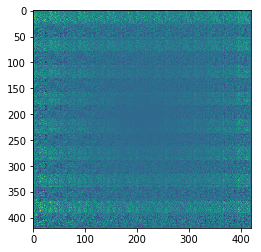

In [138]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.imshow(figure)